<hr style="border:2px solid gray"> </hr>
<img src="https://mma.prnewswire.com/media/1095203/East_Tennessee_State_University_Logo.jpg?p=facebook" width=200 height=200 />

<div class="alert alert-block alert-info">
    <h1 style="text-align: center">CSCI 5037 - NLP & Text Analysis</h1>
</div>

# <center>Topic Modeling</center>

**<center>Dr. Ahmad Al-Doulat </center>**
<center>Department of Computing </center>
<center>East Tennessee State University</center>

<hr style="border:2px solid lightblue"> </hr>

Topic modeling is an unsupervised machine learning technique that’s capable of scanning a set of documents, detecting word and phrase patterns within them, and automatically clustering word groups and similar expressions that best characterize a set of documents.

In [1]:
import string 
from collections import Counter 
from pprint import pprint 
import gzip

import matplotlib 
import matplotlib.pyplot as plt

import nltk 
from nltk.text import TextCollection

import numpy as np 
from numpy.linalg import svd 
from numpy import diag

import sklearn 
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.decomposition import NMF 
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import dendrogram 
from sklearn.decomposition import LatentDirichletAllocation

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark

Last updated: 2022-09-18T23:46:14.680757-04:00

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 151 Stepping 2, GenuineIntel
CPU cores   : 24
Architecture: 64bit



In [3]:
plt.style.use('seaborn')

# Preprocessing 

In [4]:
stopwords = nltk.corpus.stopwords.words('english')

In [5]:
list(stopwords)[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Since we'll be using tweets, we start by istantiating the TweetTokenizer. This will ensure that we preserve #tags, @usernames, etc.

In [6]:
tokenizer = nltk.tokenize.TweetTokenizer()

Process the data from the file. File was obtained from crowdflower (https://www.crowdflower.com/data-for-everyone/) and contains a list of tweets about Apple from 2014 and some information about their sentiment. For our purposes, we only care about the text of each tweet that is located in the last column of the csv file.

We treat each tweet as an individual document, and limit ourselves to only the first 200 tweets.

In [7]:
tweets = [] 
line_count = 0

for line in open("Apple-Twitter-Sentiment-DFE.CSV", "rt"):
    fields = line.strip().split(',')
    
    line_count += 1
    
    # Skip the first line of the file which contains the header 
    if line_count == 1:
        continue
    
    text = ",".join(fields [11:])

    if len(text) == 0:
        continue
    
    words = tokenizer.tokenize(text.lower())
    clean_words = []
    
    for word in words:
        if word in stopwords\
        or word in string.punctuation\
        or "/" in word:
            continue
            
        clean_words.append(word)
        
    if len(words) > 0:
        tweets.append(clean_words)
    
    if len(tweets) == 500:
        break
        
tweets[:5]

[['cat', 'chews', '@apple', 'cords', '#applesnob'],
 ['nobody', 'expects', 'spanish', 'inquisition', '#aapl'],
 ['#aapl',
  '5',
  'rocket',
  'stocks',
  'buy',
  'december',
  'gains',
  'apple',
  '...'],
 ['top', '3', '@apple', '#tablets', 'damn', 'right'],
 ['apple', 'inc', 'flash', 'crash', 'need', 'know', '#aapl']]

Define the function to calculate the Inverse Document Frequency for each word and the TFIDF matrix.

In [8]:
corpus = TextCollection(tweets)

In [9]:
corpus 

<Text: cat chews @apple cords #applesnob nobody expects spanish...>

Get the TFIDF matrix for our corpus of tweets. We should note that while we call it a matrix, this is effectively a list of dictionaries, which we can consider to be a sparse representation of a matrix.

In [10]:
TFIDF = []

for tweet in tweets:
    score = {}
    
    for token in set(tweet):
        score[token] = corpus.tf_idf(token, tweet)
        
    TFIDF.append(score)

In [11]:
TFIDF

[{'@apple': 0.090511343128403,
  'cat': 1.1042921835724493,
  '#applesnob': 1.2429216196844384,
  'chews': 1.2429216196844384,
  'cords': 1.1042921835724493},
 {'nobody': 1.2429216196844384,
  '#aapl': 0.21458890838390637,
  'expects': 1.2429216196844384,
  'spanish': 1.2429216196844384,
  'inquisition': 1.2429216196844384},
 {'...': 0.26754951207243016,
  'buy': 0.3896175441466646,
  'stocks': 0.6134956575402495,
  'rocket': 0.6905120109357991,
  '#aapl': 0.11921606021328131,
  'december': 0.5364793041447001,
  'gains': 0.6905120109357991,
  '5': 0.4742997721518754,
  'apple': 0.19177463652111687},
 {'@apple': 0.07542611927366916,
  'top': 0.852665968292347,
  '#tablets': 1.0357680164036984,
  '3': 0.8047189562170503,
  'damn': 0.8047189562170503,
  'right': 0.7371414381990228},
 {'know': 0.6578814551411559,
  'need': 0.5107929669724189,
  '#aapl': 0.15327779170279024,
  'apple': 0.24656738981286455,
  'inc': 0.48305639348085366,
  'crash': 0.6098139927666969,
  'flash': 0.65788145514

For convenience, extract the word_dict and word_list from the TFIDF matrix.

In [12]:
word_list = list(corpus.vocab().keys()) 
word_dict = dict(zip(word_list, np.arange(len(word_list))))

In [13]:
vocabulary_size = len(word_dict)
print("We have", vocabulary_size, "words in our vocabulary")

We have 1939 words in our vocabulary


In [14]:
word_list[:10]

['cat',
 'chews',
 '@apple',
 'cords',
 '#applesnob',
 'nobody',
 'expects',
 'spanish',
 'inquisition',
 '#aapl']

Now use the TFIDF matrix and our vocabulary to generate the Term Document matrix. This is just a matter of rearranging the values in our (sparse) TFIDF matrix into the full TD matrix.

In [15]:
def term_document_matrix(TFIDF, word_list, word_dict):
    vocabulary_size = len(word_dict) 
    number_documents = len(TFIDF)
    
    TDM = np.zeros((vocabulary_size, number_documents))
    
    for doc in range(number_documents):
        document = TFIDF[doc]
        
        for word in document.keys():
            pos = word_dict[word]
            
            TDM[pos, doc] = document[word]
            
    return TDM

In [16]:
TDM = term_document_matrix(TFIDF, word_list, word_dict) 
print("Our dataset has:\n%u unique words\n%u documents"%(TDM. shape))

Our dataset has:
1939 unique words
500 documents


In [17]:
TDM.shape

(1939, 500)

# Explicit Semantic Analysis

In ESA we use the TD matrix of our corpus as a knowledge base that we can use to look up related documents. To demonstrate how this works, let's create a new document:

In [18]:
new_tweet = ['#macbook', 'mini', 'rocket']

This is not an actual sentence since, for clarity, we are not including stopwords.

In the TD formulation, the values in the word (row) vector represent how much each document is "activated" by that specific word. Naturally, documents in which the word does not appear have weight zero. We can use these word vectors to find a vector representation of our new document where each value is our related it is to every other document in our knowledge base. You can think of this as the set of results one might obtain after a query in a search engine!

The find related simply calcuates the vector corresponding to the new "document" and returns a list of the corresponding weights sorted in decreasing order:

In [19]:
def find_related_docs(tweet, TDM):
    new_vector = np.zeros(TDM.shape[1]) 
    
    for word in tweet:
        pos = word_dict[word]
        new_vector += TDM[pos, :]
        
        # Now the entries of new_vector tell us which documents are activated by this one. 
        # Let's extract the list of documents sorted by activation
        doc_list = sorted(zip(range(TDM.shape[1]), new_vector),
                         key=lambda x:x[1], reverse=True)
        
        return doc_list

In [20]:
related = find_related_docs(new_tweet, TDM)

Let's take a look at the top 5 results:

In [21]:
for tweet, score in related[:10]:
    print(score, tweet, " ".join(tweets[tweet]))

0.2979625640672444 166 macbook pro 13in unboxing via @youtube @apple #macbook #macbookpro #startup #hipster #unboxing
0.2979625640672444 190 macbook pro 13in unboxing via @youtube @apple #macbook #macbookpro #startup #hipster #unboxing
0.2979625640672444 387 macbook pro 13in unboxing via @youtube @apple #macbook #macbookpro #startup #hipster #unboxing
0.27504236683130256 165 macbook pro 13 non-retina first startup via @youtube @apple #macbook #macbookpro #startup #hipster
0.27504236683130256 167 ipad mini unboxing via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unboxing
0.27504236683130256 189 macbook pro 13 non-retina first startup via @youtube @apple #macbook #macbookpro #startup #hipster
0.27504236683130256 191 ipad mini unboxing via @youtube @apple #ipadmini #ipad #macbook #macbookpro #startup #hipster #unboxing
0.27504236683130256 386 macbook pro 13 non-retina first startup via @youtube @apple #macbook #macbookpro #startup #hipster
0.27504236683130256 3

With such small documents, the results are easy to interpret. The first two result are due to mentions of macbook and mini, the third due to the presence of the word rocket but the remaining two results don't include any words in common with our original tweet, just words that appear in similar contexts.

In [22]:
def find_similar_words(tweet, TDM):
    new_vector = np.zeros(TDM.shape[1])
    
    for word in tweet:
        pos = word_dict[word]
        new_vector += TDM[pos, :] 
        
    sim = [cosine_similarity(new_vector.reshape(1, -1),
                             TDM [i, :].reshape(1, -1)).flatten()[0] for i in range(TDM.shape[0])]

    sim_words = sorted(zip(range(TDM.shape[0]), sim),
                        key=lambda x:x[1], reverse=True) 
    return sim_words

In [23]:
similar = find_similar_words(new_tweet, TDM)

In [24]:
new_tweet 

['#macbook', 'mini', 'rocket']

In [25]:
for word, score in similar[:20]: 
    print("%s: %g" % (word_list[word], score))

#macbook: 0.8216
@youtube: 0.805338
#startup: 0.805338
#hipster: 0.805338
mini: 0.787466
#ipadmini: 0.765211
#macbookpro: 0.680949
unboxing: 0.605678
#unboxing: 0.605678
startup: 0.530861
#unbox: 0.50116
#ipad: 0.467151
via: 0.452331
ipad: 0.420346
first: 0.401098
rocket: 0.388672
gains: 0.388672
pro: 0.3433
13in: 0.290492
jh: 0.2691


This approach also returns words that are not included in the document but that are used in a similar context, such as #hipster. One might use this extra words (above some finetuned threshold of similarity) to expand our query and retrieve further related documents.

# Clustering Documents

For simplicity we use the AgglomerativeClustering algorithm from sklearn and the visualization code from https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

In [26]:
def plot_dendrogram(model, **kwargs) :
    # Create linkage matrix and then plot the dendrogram
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0]) 
    n_samples = len(model.labels_)
    for i, merge in enumerate (model.children_):
        current_count = 0 
        for child_idx in merge: 
            if child_idx < n_samples:
                current_count += 1 # leaf node 
            else:
                current_count += counts[child_idx - n_samples] 
            counts[i] = current_count
            
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram 
    dendrogram(linkage_matrix, **kwargs)

Define an train the model. For the sake of visualization, we limit ourselves to just 50 documents instead of the whole set. Also note that we must use the transpose of the TDM matrix to ensure that we are clustering documents and not tokens

In [27]:
# setting distance_threshold=0 ensures we compute the full tree. 
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None) 
model = model.fit(TDM.T[:50])

We can confirm that we have the right number of features (tokens)

In [28]:
model.n_features_in_

1939

Finally, we plot the dendrogram

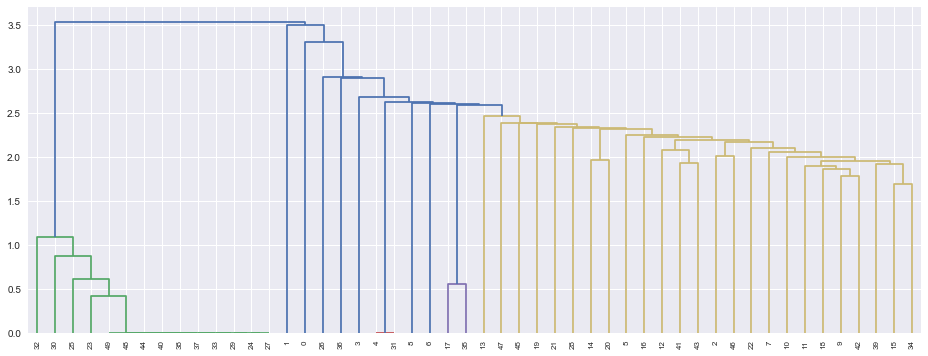

In [29]:
plt.figure(figsize=(16,6))
plot_dendrogram(model)

# Latent Semantic Analysis

LSA analysis, sometimes refered to as Latent Semantic Indexing, relies on the well known Singular Value Decomposition. Singular Values (and Singular Vectors) can be thought of as being a generalization of the more common eigenvalues (and eigenvectors) for the case of non-square matrices.

The first step in any LSA analysis is to apply SVD to the Term-Document matrix:

In [30]:
u, sigma, vt = svd(TDM)

The resulting matrices have the expected shapes, except the singular value matrix, sigma that is simply a vector. This is an optimization of the numpy function meant to save memory.

In [31]:
m, n = TDM.shape
print(u.shape, sigma.shape, vt.shape)

(1939, 1939) (500,) (500, 500)


In [32]:
print(m, n)

1939 500


We can now reduce the internal dimension of these matrices to, say, 10.

In [33]:
k = 20 

# Convert the vector of singular values into a diagonal matrix 
sigma_k = sigma[:k]
Sk = diag(sigma_k)

# Drop the extraneous dimensions in the other two matrices. 
uk = u[:,:k] 
vtk = vt[:k, :]

In this way, we preserve the most significant (higher sigma values) latent dimensions of the dataset while discarding the rest. The idea is simple, SVD projects the original dataset into an internal space which is a linear combination of the original one. Each dimension in this space can be thought of as an underlying topic in the data. By preserving only the most dominant topics in effect we are simplifying the data and, potentially, removing noise.

In [34]:
print(uk.shape, Sk.shape, vtk.shape)

(1939, 20) (20, 20) (20, 500)


There are no easy ways to determine the number of topics to choose, but a good rule of thumb is to identify kinks in the values of sigma

Text(0, 0.5, '$\\sigma_i$')

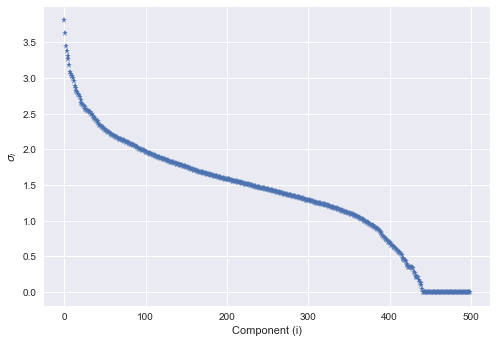

In [35]:
plt.plot(range(500), sigma, '*') 
plt.xlabel('Component (i)') 
plt.ylabel(r'$\sigma_i$')

We can also explore the way in which the topics are defined by considering the words for which they have stronger weights:

In [36]:
# Sort the list of words by the weight they have in a specific topic 
def top_words(vector, word_list):
    doc_list = sorted(zip(word_list, vector), key=lambda x:x[1], reverse=True)
    
    return doc_list

For example, for topic 1, we have strong mentions of the justice department and a recent federal law decision about unlocking iphones:

In [37]:
topic_words = top_words(uk[:,1], word_list) 
for word, weight in topic_words[:10]:
    print(word, weight)

department 0.26060224275760063
18th 0.26060224275760063
century 0.26060224275760063
cites 0.2606022427576006
federal 0.2606022427576006
law 0.2606022427576006
unlock 0.2594558729061546
justice 0.25840277676163
iphones 0.25396942955389956
@thehill 0.24845399158974724


On the other hand, if we were trying to map a specific sentence or document into the most relevant topic we would simply have to project it into the singular space. First we define the vector in the "regular" word space:

In [38]:
document = ['ipad', 'mini', 'price']

doc_vector = np.zeros(vocabulary_size)
for word in document:
    doc_vector[word_dict[word]] += 1

and now we project it into the singular space:

In [39]:
doc_singular = 1/sigma_k*np.dot(uk.T, doc_vector)
pprint(doc_singular)

array([-0.02795687, -0.01210723, -0.00019639,  0.00096848,  0.01986759,
        0.00152401, -0.02277111,  0.06085907,  0.0134054 ,  0.03140215,
        0.00564585,  0.0869532 ,  0.03682714, -0.00405679,  0.01681271,
        0.01352978, -0.0132486 ,  0.02266492, -0.01178019, -0.00777679])


From where we see that the most relevant topic is topic number 11:

In [40]:
topic = np.argmax (doc_singular)

print(topic)

topic_words = top_words(uk[:, topic], word_list)
for word, weight in topic_words[:20]:
    print (word, weight)

11
thank 0.2977455733150199
#macbookpro 0.2590956505044576
via 0.2412041080225189
@youtube 0.23935595752767863
#startup 0.23935595752767863
#hipster 0.23935595752767863
#macbook 0.23480658188636316
yall 0.17203078651125117
unboxing 0.15616835737157547
#unboxing 0.15616835737157547
ipad 0.1458615242330166
pro 0.1403175419202504
mini 0.13966101518736163
#ipadmini 0.13721958345536442
update 0.13650380565448605
#ipad 0.13097471890592277
headphones 0.1303155545462927
startup 0.127670760375614
hoes 0.12703314328093984
first 0.12423438613474062


# Latent Dirichlett Allocation

In [41]:
lda = LatentDirichletAllocation(n_components=15, random_state= 42)
lda.fit(TDM.T)

LatentDirichletAllocation(n_components=15, random_state=42)

In [42]:
lda.components_.shape

(15, 1939)

In [1]:
for i, topic in enumerate(lda.components_):
    print("Topic {}: {}".format(i + 1, ", ".join([str(x) for x in np.array(word_list)[topic.argsort()[-10:]]])))

NameError: name 'lda' is not defined

# Non-Negative Matrix Factorization

The idea behind applying NMF to a Term-Document Matrix is similar to the goals behind using SVD to perform Latent Semantic Analysis. NMF is a general matrix factorization algorithm and, as such, the factor matrices it finds can also be thought of as internal or latent dimensions.

Similarly to the case of SVD, we can perform a partial reconstruction of the original matrix by reducing the internal dimensions. Naturally, as the number of latent dimensions increases, the reconstruction error decreases since we are removing less and less information:

Let's see how the error changes with the number of components.

In [44]:
error = []

for comps in range(2, 55+1):
    nmf = NMF(n_components=comps, init='nndsvd', max_iter=2000).fit(TDM.T)
    print(comps, nmf.reconstruction_err_)
    error.append(nmf.reconstruction_err_)

2 34.92909306541825
3 34.75885142606
4 34.5947458446712
5 34.43673790752642
6 34.283354611350376
7 34.14211165068757
8 34.004422096185664
9 33.87122655062463
10 33.73252271899094
11 33.59876519824155
12 33.46638003125052
13 33.335654459350295
14 33.211815089916605
15 33.08995473154768
16 32.97022562227948
17 32.85160111592217
18 32.73794535446866
19 32.62233364690955
20 32.52685571893301
21 32.39721240834996
22 32.29220451623176
23 32.191634845809304
24 32.08141666493552
25 31.986568747100026
26 31.897249306987916
27 31.779439916630697
28 31.67887867900326
29 31.584367387891064
30 31.48552189801245
31 31.38221566631322
32 31.277407216451497
33 31.186928524133748
34 31.085261305683293
35 30.987095902844153
36 30.89489098707695
37 30.789463346181105
38 30.695359606501384
39 30.597544726823372
40 30.50807832563129
41 30.41249225435553
42 30.31885780380896
43 30.263097212377293
44 30.158495203196253
45 30.06807068304215
46 29.999344750024484
47 29.899147123324685
48 29.810772000375614
49 2

The nan values found above are due to numerical instabilities. In practice you should use a well tested numerical library such as sklearn.

Text(0.5, 1.0, 'Non-Negative Matrix Factorization')

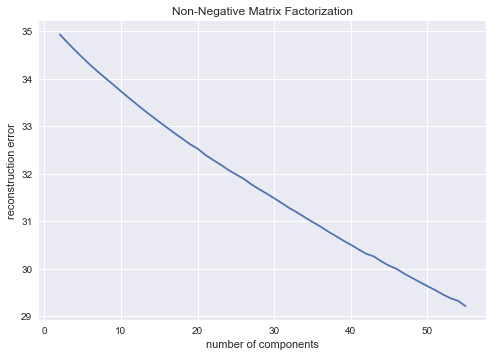

In [45]:
plt.plot(range(2, 55+1), error)
plt.xlabel('number of components')
plt.ylabel('reconstruction error')
plt.title('Non-Negative Matrix Factorization')

For the remainder of this section, lets fix the number of so that we can use these results to illustrate the power of NMF.

In [46]:
nmf = NMF(n_components=10, init='nndsvd', max_iter=2000)
W = nmf.fit_transform(TDM.T)
H = nmf.components_
err = nmf.reconstruction_err_

In [47]:
W.shape

(500, 10)

When we apply NMF to a Term-Document matrix, as defined above, the resulting factors prove useful for topic detection. In particular, the W matrix provides us with the definition of each topic as a weighted distribution over all the words in the corpus:

Let's look at a couple of examples:

In [48]:
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i + 1, ", ".join([str(x) for x in np.array(word_list)[topic.argsort()[-10:]]])))

Topic 1: @jpdesloges, last, #aapl, apple, aapl, update, levels, technicals, fibonacci, intraday
Topic 2: @thehill, iphones, justice, unlock, federal, law, department, cites, century, 18th
Topic 3: @apple, right, imessage, acid, shitty, yo, draining, 3g, @remuuusss, fix
Topic 4: comparison, map, drop, ios, requirement, rendition, audio, @apple, apps, #ipodtouch5thgen
Topic 5: #hipster, #macbookpro, #macbook, rt, apple, @ace_kit_uk, macbook, å, £, 949.86
Topic 6: ur, course, mother, that's, keeps, freezing, shit, hate, faggots, fucking
Topic 7: heads, inc, steve, jobs, trial, apple, cnbctv, ..., #apple, #aapl
Topic 8: solution, people, thank, rt, @apple, @jodispicer, #passingthetime, #whoknew, #interestingfact, twitter
Topic 9: slack, boys, music, breaking, cause, @brwnskin_beauti, lol, dying, hey, fuck
Topic 10: please, thank, @apple, @laurrynk, yall, replace, battery, sucks, phone, dear
